In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
import math
import pywt

In [35]:
retina_df = pd.read_csv("../Data/Retina_DF_BalType_Multi_700_FiveClass.csv")
retina_df.sample(5)

,image,level,multi_type,multi_level
146,28743_left,4,PROLIFERATIVE DR,4
2880,217_right,4,PROLIFERATIVE DR,4
716,18874_left,0,NO DR,0
3017,20402_right,3,SEVERE,3
2006,37332_left,4,PROLIFERATIVE DR,4


In [36]:
retina_df.head(5)

,image,level,multi_type,multi_level
0,14119_right,0,NO DR,0
1,23692_left,4,PROLIFERATIVE DR,4
2,22379_right,4,PROLIFERATIVE DR,4
3,4165_left,0,NO DR,0
4,8637_right,1,MILD,1


In [37]:
tam_image = 256

In [38]:
N = retina_df.shape[0]
imagenes_retina_mod = np.empty((N, tam_image, tam_image, 3), dtype=np.uint8)
ruta_imagenes = "../Data/Train/"
imagenes_retina = []

In [39]:
for index, path in enumerate(tqdm(retina_df['image'], desc="Cargando Imagenes: ")):
    img_aux = cv2.imread(ruta_imagenes+path+".jpeg")
    img_aux = cv2.cvtColor(img_aux, cv2.COLOR_BGR2RGB)
    img_aux = cv2.resize(img_aux,(tam_image,tam_image),interpolation=cv2.INTER_LANCZOS4)

    # if index == 10:
    #     break;

    imagenes_retina.append(img_aux)

Cargando Imagenes: 100%|██████████| 3500/3500 [07:26<00:00,  7.83it/s]


In [40]:
def mostrar_grafica(n_ren, n_col, list_image):
    fig, ax = plt.subplots(n_ren, n_col)

    for index in range(n_col*n_ren):
        #print(index//n_col, index%n_col)
        val_plot = ax[index//n_col, index%n_col]
        val_plot.axis("off")
        val_plot.imshow(list_image[index], cmap="gray")
        val_plot.title.set_text(retina_df['multi_type'][index])
        
    plt.tight_layout()
    plt.show()

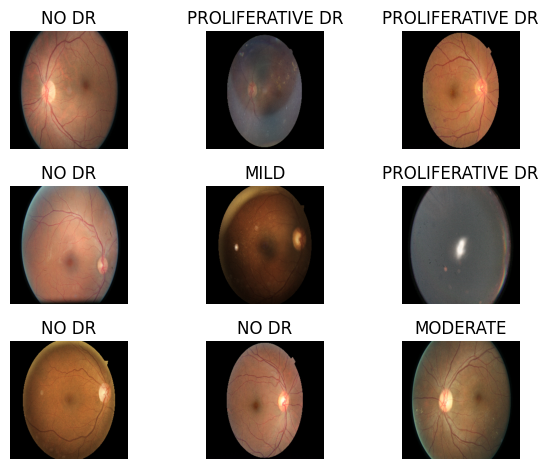

In [41]:
mostrar_grafica(n_col=3, n_ren=3, list_image=imagenes_retina)

#### PREPROCESAMIENTO

In [42]:
def ajuste_brillo_contraste(image):
    mean, stddev = cv2.meanStdDev(image)
    mediana = np.percentile(image.flatten(), 50)
    ax = 128 - mediana
    alpha = np.clip(100 / (stddev[0][0] + 1e-6), 1.0, 2.0)
    beta = np.clip(ax - mean[0][0], -30, 30)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

In [43]:
def clip_limit_adaptativo(image, base_clip=2.0, scale_factor=5.0, min_limit=0.5, max_limit=2.0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std_dev = np.std(gray_image)
    
    normalized_std = std_dev / 255  
    clip_limit = base_clip + (normalized_std * scale_factor)

    return np.clip(clip_limit, min_limit, max_limit)

In [44]:
def clahe_funcion(image):
    clip_limit_value = min(clip_limit_adaptativo(image), 2.0)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit_value, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l_clahe, a, b)), cv2.COLOR_LAB2BGR)

In [45]:
def recorte_Bordes(img_sinReco):
    gray_image = cv2.cvtColor(img_sinReco, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
    contorno, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contorno:
        return cv2.resize(img_sinReco, (tam_image, tam_image))

    cont = max(contorno, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(cont)
    Imag_recort = img_sinReco[y:y+h, x:x+w]
    Imag_recort = cv2.resize(Imag_recort,(tam_image,tam_image))
    
    return Imag_recort

In [46]:
def auto_gammaCorrection(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    mean = np.mean(v)
    gamma = np.clip(math.log(0.5 * 255) / math.log(mean), 0.8, 1.2)
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

In [47]:
def apply_wavelet_enhancement(channel, wavelet='db4', level=3, factors=(1.5, 1.5, 2.0)):
    """
    Aplica mejora por wavelets a un solo canal de imagen (2D).
    
    Parámetros:
    - channel: np.ndarray, canal de imagen (2D).
    - wavelet: str, tipo de wavelet a usar.
    - level: int, número de niveles de descomposición.
    - factors: tuple, factores de amplificación para detalles (H, V, D).

    Retorna:
    - enhanced_channel: np.ndarray, canal mejorado (uint8).
    """
    # Verifica que el canal sea 2D
    if channel.ndim != 2:
        raise ValueError("El canal de entrada debe ser una matriz 2D.")

    # Realiza la descomposición wavelet
    coeffs = pywt.wavedec2(channel, wavelet=wavelet, level=level)
    coeffs_H = [coeffs[0]]  # Coeficientes aproximados (sin cambios)

    # Aplica factores a los coeficientes de detalle
    for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
        factor_h = factors[0] if len(factors) > 0 else 1.0
        factor_v = factors[1] if len(factors) > 1 else 1.0
        factor_d = factors[2] if len(factors) > 2 else 1.0

        coeffs_H.append((
            cH * factor_h,
            cV * factor_v,
            cD * factor_d,
        ))

    # Reconstruye la imagen
    enhanced_channel = pywt.waverec2(coeffs_H, wavelet=wavelet)

    # Recorta el tamaño si es necesario (por padding interno de pywt)
    enhanced_channel = enhanced_channel[:channel.shape[0], :channel.shape[1]]

    # Clipping y conversión a uint8
    enhanced_channel = np.clip(enhanced_channel, 0, 255)
    return enhanced_channel.astype(np.uint8)

In [48]:
# def apply_wavelet_enhancement(channel, wavelet='db4', level=3, factors=(1.5, 1.5, 2.0)):
#     coeffs = pywt.wavedec2(channel, wavelet, level=level)
#     coeffs_H = list(coeffs)

#     for i in range(1, len(coeffs_H)):
#         cH, cV, cD = coeffs_H[i]
#         coeffs_H[i] = (
#             cH * factors[0],  # Horizontal
#             cV * factors[1],  # Vertical
#             cD * factors[2],  # Diagonal
#         )

#     enhanced_channel = pywt.waverec2(coeffs_H, wavelet)
#     enhanced_channel = np.clip(enhanced_channel, 0, 255)
#     return np.uint8(enhanced_channel)


In [49]:
def wavelet(imagen):
    R, G, B = cv2.split(imagen)
    R_enhanced = apply_wavelet_enhancement(R)
    G_enhanced = apply_wavelet_enhancement(G)
    B_enhanced = apply_wavelet_enhancement(B)
    
    return cv2.merge((R_enhanced, G_enhanced, B_enhanced))

In [50]:
def filtrado_bilateral(image):
    return cv2.bilateralFilter(image,9,5,5)

In [51]:
def reduccion_ruido(image):
    return cv2.fastNlMeansDenoisingColored(image, h=7, templateWindowSize=8, searchWindowSize=21)

In [52]:
def enmascarar_circular(img):
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (w//2, h//2), min(h, w)//2 - 10, 255, -1)
    return cv2.bitwise_and(img, img, mask=mask)

In [53]:
def normalizar(image):
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / std

In [54]:
for index in tqdm(range(len(imagenes_retina))):
    image_aux = imagenes_retina[index]

    #---------
    
    image_aux = filtrado_bilateral(image_aux)
    image_aux = recorte_Bordes(image_aux)
    image_aux = ajuste_brillo_contraste(image_aux)
    image_aux = clahe_funcion(image_aux)
    image_aux = auto_gammaCorrection(image_aux)
    #image_aux = wavelet(image_aux)

    # image_aux = filtrado_bilateral(image_aux)
    # image_aux = recorte_Bordes(image_aux)
    # image_aux = ajuste_brillo_contraste(image_aux)
    # image_aux = auto_gammaCorrection(image_aux)
    # image_aux = clahe_funcion(image_aux)
    #image_aux = wavelet(image_aux)
    
    #----------
    # GUARDADO DE IMAGENES
    imagenes_retina_mod[index] = image_aux

100%|██████████| 3500/3500 [01:26<00:00, 40.30it/s]


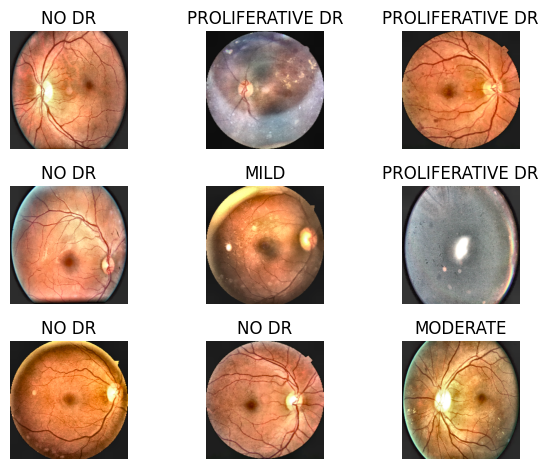

In [55]:
mostrar_grafica(n_col=3, n_ren=3, list_image=imagenes_retina_mod)

In [56]:
mk_direccion = "../Data/Img_Preprocessing_Multi_FiveClass/"
etiquetas = ['NO DR', 'MILD', 'MODERATE', 'SEVERE', 'PROLIFERATIVE DR']

In [57]:
try:
    os.mkdir("../Data/Img_Preprocessing_Multi_FiveClass")
    print(f" ✔️ La carpeta {"Img_Preprocessing_Binary"} se creo correctamente")
except Exception as e:
    print(f" ⚠️ Ocurrió un error inesperado: {e}")

 ✔️ La carpeta Img_Preprocessing_Binary se creo correctamente


In [58]:
for index in range(len(etiquetas)):
    try:
        os.mkdir(mk_direccion+etiquetas[index])
        print(f" ✔️ La carpeta {etiquetas[index]} se creo correctamente")
    except FileExistsError:
        print(f" ❌ La carpeta {etiquetas[index]} ya existe")
    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")


 ✔️ La carpeta NO DR se creo correctamente
 ✔️ La carpeta MILD se creo correctamente
 ✔️ La carpeta MODERATE se creo correctamente
 ✔️ La carpeta SEVERE se creo correctamente
 ✔️ La carpeta PROLIFERATIVE DR se creo correctamente


In [59]:
for index in range(len(imagenes_retina_mod)):
    try:
        tipo = etiquetas[retina_df["multi_level"][index]]
        nombre_img = retina_df['image'][index]
        ruta = os.path.join(mk_direccion, tipo, f"{nombre_img}.png")

        if os.path.exists(ruta):
            print(f" ❌ La Imagen {nombre_img} ya existe")
            continue

        img = imagenes_retina_mod[index]
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_norm.astype(np.uint8)
        cv2.imwrite(ruta, cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))

    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")
